# 3. Finish the search problem

## 1. Get data from web page.

In [1]:
import requests
import re
import collections
from bs4 import BeautifulSoup

In [2]:
headers={
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.131 Safari/537.36'
}

def crawl(url):
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup


In [82]:
bj_subway_url = 'https://baike.baidu.com/item/%E5%8C%97%E4%BA%AC%E5%9C%B0%E9%93%81/408485'
source_soup = crawl(bj_subway_url)

In [3]:
jh_url = 'https://baike.baidu.com/guanxi/jsondata?action=getViewLemmaData&args=%5B0%2C8%2C%7B%22fentryTableId%22%3A10469%2C%22lemmaId%22%3A14765801%2C%22subLemmaId%22%3A14765801%7D%2Ctrue%5D'
rsp = requests.get(jh_url, headers=headers)
json = rsp.json()
html = json['html']
jh_soup = BeautifulSoup(html, 'html.parser', from_encoding='utf-8')

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:179: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")


In [6]:
lines = jh_soup.find_all('a')

In [16]:
lines = source_soup.findAll('table')[4].findAll('a')[:-1]

In [7]:
lines

[<a class="link-inner" href="http://baike.baidu.com/subview/1156802/1156802.htm" target="_blank" title="北京地铁1号线">北京地铁1号线</a>,
 <a class="link-inner" href="http://baike.baidu.com/subview/1733388/1733388.htm" target="_blank" title="北京地铁2号线">北京地铁2号线</a>,
 <a class="link-inner" href="http://baike.baidu.com/view/1329286.htm" target="_blank" title="北京地铁4号线">北京地铁4号线</a>,
 <a class="link-inner" href="http://baike.baidu.com/subview/1079997/1079997.htm" target="_blank" title="北京地铁5号线">北京地铁5号线</a>,
 <a class="link-inner" href="http://baike.baidu.com/subview/2157542/2157542.htm" target="_blank" title="北京地铁8号线">北京地铁8号线</a>,
 <a class="link-inner" href="http://baike.baidu.com/subview/393486/393486.htm" target="_blank" title="北京地铁9号线">北京地铁9号线</a>,
 <a class="link-inner" href="http://baike.baidu.com/subview/1376596/1376596.htm" target="_blank" title="北京地铁10号线">北京地铁10号线</a>,
 <a class="link-inner" href="http://baike.baidu.com/subview/6152850/6237342.htm" target="_blank" title="北京地铁13号线">北京地铁13号线</a>,
 

## 2. Preprocessing data from page source.

In [38]:
stations_connection = collections.defaultdict(list)
dist = collections.defaultdict(int)
node_in_line = collections.defaultdict(set)

subway_name_list = []

pattern = re.compile('([\w|\d]+)相邻站间距信息统计表')

for line in lines[:]:
    link = line.get('href')
    soup = crawl(link)

    for caption in soup.find_all('caption'):
        line_name = re.findall(pattern, caption.get_text())
        if line_name:
            if '北京地铁机场线' in line_name:
                line_name = ['机场线']
            subway_name_list.append(line_name)
            print('\n----The information of {} is following...'.format(line_name[0]))
            table = caption.find_parent('table')
            for neigbor in table.find_all('tr')[1:]:
                if '机场线' in line_name:
                    if not re.findall(re.compile('([\w|\d]+)——([\w|\d]+)'), neigbor.find_all('td')[0].text):
                        continue
                    start, end = re.findall(re.compile('([\w|\d]+)——([\w|\d]+)'), neigbor.find_all('td')[0].text)[0]
                    distance = re.findall(re.compile('([\d]+)米*'), neigbor.find_all('td')[1].text)[0]
                else:
                    start, end = re.findall(re.compile('([\w|\d]+)——([\w|\d]+)'), neigbor.th.text)[0]
                    distance = re.findall(re.compile('([\d]+)米*'), neigbor.td.text)[0]

                if end not in stations_connection[start]:
                    stations_connection[start].append(end)
                if start not in stations_connection[end]:
                    stations_connection[end].append(start)

                dist[(start,end)] = dist[(end,start)] = int(distance)
    
                node_in_line[start].add(line_name[0])
                node_in_line[end].add(line_name[0])

                print('{}<-->{}: {}m'.format(start, end, distance))

            break
print(dist)


----The information of 2号线 is following...
西直门<-->车公庄: 909m
车公庄<-->阜成门: 960m
阜成门<-->复兴门: 1832m
复兴门<-->长椿街: 1234m
长椿街<-->宣武门: 929m
宣武门<-->和平门: 851m
和平门<-->前门: 1171m
前门<-->崇文门: 1634m
崇文门<-->北京站: 1023m
北京站<-->建国门: 945m
建国门<-->朝阳门: 1763m
朝阳门<-->东四十条: 1027m
东四十条<-->东直门: 824m
东直门<-->雍和宫: 2228m
雍和宫<-->安定门: 794m
安定门<-->鼓楼大街: 1237m
鼓楼大街<-->积水潭: 1766m
积水潭<-->西直门: 1899m

----The information of 4号线 is following...
安河桥北<-->北宫门: 1363m
北宫门<-->西苑: 1251m
西苑<-->圆明园: 1672m
圆明园<-->北京大学东门: 1295m
北京大学东门<-->中关村: 887m
中关村<-->海淀黄庄: 900m
海淀黄庄<-->人民大学: 1063m
人民大学<-->魏公村: 1051m
魏公村<-->国家图书馆: 1658m
国家图书馆<-->动物园: 1517m
动物园<-->西直门: 1441m
西直门<-->新街口: 1025m
新街口<-->平安里: 1100m
平安里<-->西四: 1100m
西四<-->灵境胡同: 869m
灵境胡同<-->西单: 1011m
西单<-->宣武门: 815m
宣武门<-->菜市口: 1152m
菜市口<-->陶然亭: 1200m
陶然亭<-->北京南站: 1643m
北京南站<-->马家堡: 1480m
马家堡<-->角门西: 827m
角门西<-->公益西桥: 989m

----The information of 5号线 is following...
天通苑北<-->天通苑: 939m
天通苑<-->天通苑南: 965m
天通苑南<-->立水桥: 1544m
立水桥<-->立水桥南: 1305m
立水桥南<-->北苑路北: 1286m
北苑路北<-->大屯路东: 3m
大屯路东<-->惠新西街北口: 

In [9]:
should_have_lines = []
extra_lines = [['机场线'], ['八通线'], ['大兴线'], ['亦庄线']]
for i in range(15):
    # 5、13、14号线未规划，3号线（->6号线）、11号线（->10号线）取消，12号线待建成（算法中需特殊处理）
    
    if i + 1 in (3, 5, 11, 13, 14):
        continue
    should_have_lines.append(['{}号线'.format(i + 1)])
should_have_lines += extra_lines

special_process_line = []
for line in should_have_lines:
    if line not in subway_name_list:
        special_process_line.append(line)

print(special_process_line)
# print(subway_name_list)

[['1号线'], ['8号线'], ['9号线'], ['12号线'], ['亦庄线']]


In [164]:
lines_total_distance = {
    '1号线': 31870,
    '8号线': 45600,
    '9号线': 16500,
    '12号线': 27000,
    '亦庄线': 23300
}

for line in lines[:]:
    line_name = [line.get('title')[4:]]
    if line_name in special_process_line:
        link = line.get('href')
        soup = crawl(link)
        print(soup.find_all('caption'))
                
                

[<caption>北京地铁1号线车站列表</caption>]
[<caption>8号线三期南延计划</caption>, <caption>北京地铁8号线车站列表</caption>, <caption>北京地铁8号线（北段）车站信息</caption>, <caption>北京地铁8号线（南段）车站信息</caption>, <caption>北京地铁8号线相邻站间距信息统计表</caption>, <caption>北京地铁8号线（北段）首末车时刻表<br/>　　</caption>, <caption>北京地铁8号线（南段）首末车时刻表</caption>, <caption>北京地铁8号线无障碍服务设施表</caption>]
[<caption>北京地铁9号线车站列表</caption>, <caption>北京地铁9号线首末车时刻表</caption>]
[<caption>北京地铁12号线线路数据</caption>]
[<caption>北京地铁亦庄线线路数据</caption>, <caption>北京地铁亦庄线车站信息</caption>, <caption>亦庄线标志色数据</caption>]


### 说明：1、8、9、12号线、亦庄线无站点距离信息

In [10]:
stations_connection

defaultdict(list,
            {'西直门': ['车公庄', '积水潭', '动物园', '新街口', '大钟寺'],
             '车公庄': ['西直门', '阜成门', '车公庄西', '平安里'],
             '阜成门': ['车公庄', '复兴门'],
             '复兴门': ['阜成门', '长椿街'],
             '长椿街': ['复兴门', '宣武门'],
             '宣武门': ['长椿街', '和平门', '西单', '菜市口'],
             '和平门': ['宣武门', '前门'],
             '前门': ['和平门', '崇文门'],
             '崇文门': ['前门', '北京站', '东单', '磁器口'],
             '北京站': ['崇文门', '建国门'],
             '建国门': ['北京站', '朝阳门'],
             '朝阳门': ['建国门', '东四十条', '东四', '东大桥'],
             '东四十条': ['朝阳门', '东直门'],
             '东直门': ['东四十条', '雍和宫', '柳芳', '三元桥'],
             '雍和宫': ['东直门', '安定门', '和平里北街', '北新桥'],
             '安定门': ['雍和宫', '鼓楼大街'],
             '鼓楼大街': ['安定门', '积水潭', '安德里北街', '什刹海'],
             '积水潭': ['鼓楼大街', '西直门'],
             '安河桥北': ['北宫门'],
             '北宫门': ['安河桥北', '西苑'],
             '西苑': ['北宫门', '圆明园'],
             '圆明园': ['西苑', '北京大学东门'],
             '北京大学东门': ['圆明园', '中关村'],
             '中关村': ['北京大学东门', '海

In [12]:
import networkx as nx
import matplotlib as plt
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


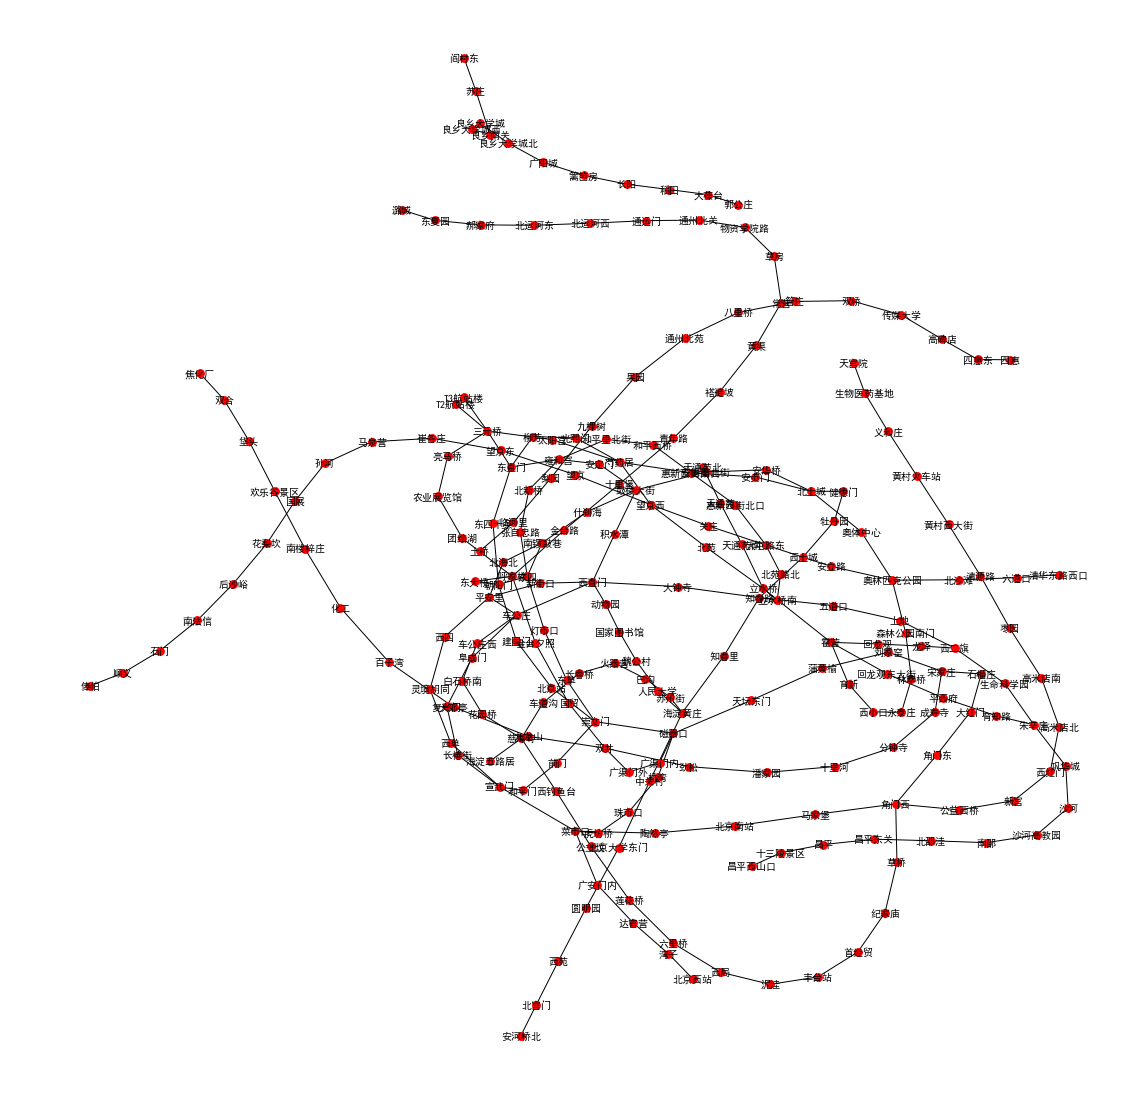

In [13]:
subway_graph = nx.Graph(stations_connection)
# nx.draw(subway_graph, with_labels=True, node_size=200)

plt.figure(1,figsize=(15,15)) 
nx.draw(subway_graph, node_size=60, font_size=10, with_labels=True)
plt.show()

## 3. Build the search agent

In [14]:
def is_goal(desitination, by_way=[]):
    def _wrap(current_path):
        for s in by_way:
            if s not in current_path:
                return False
        return current_path[-1] == desitination
    return _wrap

In [15]:
def sort_path(cmp_func, beam=-1):
    def _sorted(pathes):
        if beam == -1:
            return sorted(pathes, key=cmp_func)
        else:
            return sorted(pathes, key=cmp_func)[:beam]
    return _sorted

In [16]:
node_in_line['西直门'] & node_in_line['车公庄']

{'2号线'}

In [17]:
# 最小换乘
def get_total_swaps(path):
    
    if len(path) < 2:
        return 0
    
    res = 0
    pre_line = node_in_line[path[0]] &  node_in_line[path[1]]
    pre = path[1]
    
    for station in path[2:]:
        
        cur_line = node_in_line[station] &  node_in_line[pre]
        if cur_line != pre_line:
            res += 1
            
        pre_line = cur_line
        pre = station

    return res

In [20]:
# 路程最短优先
def get_path_distance(path):
    
    distance = 0
    
    for i, c in enumerate(path[:-1]):
        distance += dist[(c, path[i+1])]
    
    return distance

In [21]:
def search(graph, start, is_goal, search_stratery):

    pathes = [[start]]
    seen = set()
    
    while pathes:
        path = pathes.pop(0)
        frontier = path[-1]

#         if frontier in seen:    continue
         
        for station in graph[frontier]:
            if station in path: continue

            new_path = path + [station]
            pathes.append(new_path)
            
            if is_goal(new_path):   return new_path

#         seen.add(frontier)
        pathes = search_stratery(pathes)

### 最小换乘优先

In [41]:
search(stations_connection, start='东单', is_goal=is_goal('中关村'), search_stratery=sort_path(get_total_swaps))

['东单',
 '灯市口',
 '东四',
 '张自忠路',
 '北新桥',
 '雍和宫',
 '和平里北街',
 '和平西桥',
 '惠新西街南口',
 '安贞门',
 '北土城',
 '健德门',
 '牡丹园',
 '西土城',
 '知春路',
 '知春里',
 '海淀黄庄',
 '中关村']

### 最短路程优先

In [42]:
search(stations_connection, start='东单', is_goal=is_goal('中关村'), search_stratery=sort_path(get_path_distance))

['东单',
 '灯市口',
 '东四',
 '南锣鼓巷',
 '北海北',
 '平安里',
 '新街口',
 '西直门',
 '大钟寺',
 '知春路',
 '知春里',
 '海淀黄庄',
 '中关村']

###  Continuous transfer

In [43]:
search(stations_connection, start='东单', is_goal=is_goal('中关村', by_way=['车公庄西']), search_stratery=sort_path(get_path_distance))

['东单',
 '灯市口',
 '东四',
 '南锣鼓巷',
 '北海北',
 '平安里',
 '车公庄',
 '车公庄西',
 '白石桥南',
 '花园桥',
 '慈寿寺',
 '车道沟',
 '长春桥',
 '火器营',
 '巴沟',
 '苏州街',
 '海淀黄庄',
 '中关村']